In [5]:
import torch
from tqdm import tqdm
# Check if CUDA is available and being used
cuda_available = torch.cuda.is_available()
current_device = torch.cuda.current_device() if cuda_available else 'CPU'
device_name = torch.cuda.get_device_name(current_device) if cuda_available else 'CPU'

print(f"CUDA Available: {cuda_available}")
print(f"Current Device: {current_device}")
print(f"Device Name: {device_name}")

CUDA Available: True
Current Device: 0
Device Name: NVIDIA TITAN X (Pascal)


In [2]:
import json
import matplotlib.pyplot as plt
from os import path
from torch.utils.data import DataLoader

from models.glow_model.train import get_ds_params
from models.glow_model.model import Glow
from utilities.routes import OUTPUT_DIR

device = torch.device("cuda")
def load_model(ds_name, checkpoint, device):
    
    transform =None
    dataset_output = "output_full/"
    # dataset_output = "output_lastresult/"
    model_type = 'glow'

    dataset_output_dir = path.join(dataset_output, f"{model_type}_{ds_name}/")

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
    image_shape, num_classes, _, test_ds = get_ds_params(ds_name, hparams['dataroot'], transform, hparams['augment'], hparams['download'],mode='test')
    model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
                hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
                hparams['learn_top'], hparams['y_condition'])

    model.load_state_dict(torch.load(dataset_output_dir + checkpoint)['model']) # Load only model part
    model.set_actnorm_init()

    model = model.to(device)

    model = model.eval()
    return test_ds, model

/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [3]:
def compute_nll(dataset, model):
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False)
    nlls = []
    for x,y in dataloader:
        x = x.to(device)
        y = None
        
        with torch.no_grad():
            _, nll, _ = model(x, y_onehot=y)
            nlls.append(nll)
        
    return torch.cat(nlls).cpu()

In [4]:
epoch = 250 #10 250
if epoch==1:
    cifar10_chk = 'glow_checkpoint_781.pt'
    svhn_chk = 'glow_checkpoint_1144.pt'
    imagenet32_chk = 'glow_checkpoint_2001.pt'
    celeba_chk = 'glow_checkpoint_2532.pt'
    gtsrb_chk = 'glow_checkpoint_416.pt'
    epo_info = "One epoch"
elif epoch==10:
    cifar10_chk = 'glow_checkpoint_7810.pt'
    svhn_chk = 'glow_checkpoint_11440.pt'
    imagenet32_chk = 'glow_checkpoint_20010.pt'
    celeba_chk = 'glow_checkpoint_25320.pt'
    gtsrb_chk = 'glow_checkpoint_4160.pt'
    epo_info = "Ten epochs"
elif epoch==250:
    cifar10_chk = 'glow_checkpoint_195250.pt'
    svhn_chk = 'glow_checkpoint_286000.pt'
    imagenet32_chk = 'glow_checkpoint_500250.pt'
    celeba_chk = 'glow_checkpoint_633000.pt'
    gtsrb_chk = 'glow_checkpoint_104000.pt'
    epo_info = "Fully trained"

def load_ds(ds_name):
    
    transform =None
    dataset_output = "output_full/"
    # dataset_output = "output_lastresult/"
    model_type = 'glow'

    dataset_output_dir = path.join(dataset_output, f"{model_type}_{ds_name}/")

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
    image_shape, num_classes, _, test_ds = get_ds_params(ds_name, hparams['dataroot'], transform, hparams['augment'], hparams['download'],mode='test')
    return test_ds

# celeba_test, model = load_model('celeba', celeba_chk, device)
imagenet32_test, model = load_model('imagenet32', imagenet32_chk, device)
# gtsrb_test, model = load_model('gtsrb', gtsrb_chk, device)
# gtsrb_nll = compute_nll(gtsrb_test, model)
# svhn_test, model = load_model('svhn', svhn_chk, device)
svhn_test = load_ds('svhn')
svhn_nll = compute_nll(svhn_test, model)
# imagenet32_test = load_ds('imagenet32')
imagenet32_nll = compute_nll(imagenet32_test, model)
cifar_test = load_ds('cifar10')
cifar_nll = compute_nll(cifar_test, model)
celeba_test = load_ds('celeba')
celeba_nll = compute_nll(celeba_test, model)
gtsrb_test = load_ds('gtsrb')
gtsrb_nll = compute_nll(gtsrb_test, model)


print("CIFAR NLL", torch.mean(cifar_nll))
print("SVHN NLL", torch.mean(svhn_nll))
print("Imagenet32 NLL", torch.mean(imagenet32_nll))
print("Celeba NLL", torch.mean(celeba_nll))
print("GTSRB NLL", torch.mean(gtsrb_nll))

Total entries in LMDB: 50000


Loading validation data of ImageNet32: 100%|██████████| 50000/50000 [00:10<00:00, 4700.39it/s]
/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/models/glow_model/modules.py:482: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  w_init = torch.qr(torch.randn(*w_shape))[0]
/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/torch/functional.py:1924: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute

KeyboardInterrupt: 

In [4]:
# # Compute nll under GLOW model
# epoch = 10 #10 250
# if epoch==1:
#     cifar10_chk = 'glow_checkpoint_781.pt'
#     svhn_chk = 'glow_checkpoint_1144.pt'
#     imagenet32_chk = 'glow_checkpoint_2001.pt'
#     celeba_chk = 'glow_checkpoint_2532.pt'
#     gtsrb_chk = 'glow_checkpoint_416.pt'
#     epo_info = "One epoch"
# elif epoch==10:
#     cifar10_chk = 'glow_checkpoint_7810.pt'
#     svhn_chk = 'glow_checkpoint_11440.pt'
#     imagenet32_chk = 'glow_checkpoint_20010.pt'
#     celeba_chk = 'glow_checkpoint_25320.pt'
#     gtsrb_chk = 'glow_checkpoint_4160.pt'
#     epo_info = "Ten epochs"
# elif epoch==250:
#     cifar10_chk = 'glow_checkpoint_195250.pt'
#     svhn_chk = 'glow_checkpoint_286000.pt'
#     imagenet32_chk = 'glow_checkpoint_500250.pt'
#     celeba_chk = 'glow_checkpoint_633000.pt'
#     gtsrb_chk = 'glow_checkpoint_104000.pt'
#     epo_info = "Fully trained"



# cifar_test, cifar_model = load_model('cifar10', cifar10_chk, device)
# cifar_nll = compute_nll(cifar_test, cifar_model)
# svhn_test, svhn_model = load_model('svhn', svhn_chk, device)
# svhn_nll = compute_nll(svhn_test, svhn_model)
# imagenet32_test, imagenet32_model = load_model('imagenet32', imagenet32_chk, device)
# imagenet32_nll = compute_nll(imagenet32_test, imagenet32_model)
# celeba_test, celeba_model = load_model('celeba', celeba_chk, device)
# celeba_nll = compute_nll(celeba_test, celeba_model)
# gtsrb_test, gtsrb_model = load_model('gtsrb', gtsrb_chk, device)
# gtsrb_nll = compute_nll(gtsrb_test, gtsrb_model)


# print("CIFAR NLL", torch.mean(cifar_nll))
# print("SVHN NLL", torch.mean(svhn_nll))
# print("Imagenet32 NLL", torch.mean(imagenet32_nll))
# print("Celeba NLL", torch.mean(celeba_nll))
# print("GTSRB NLL", torch.mean(gtsrb_nll))

/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/models/glow_model/modules.py:482: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  w_init = torch.qr(torch.randn(*w_shape))[0]
/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/torch/functional.py:1924: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced 

Using downloaded and verified file: /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/data/SVHN/test_32x32.mat


/tmp/ipykernel_1909709/2630891841.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dataset_output_dir + checkpoint)['model']) # Load onl

Total entries in LMDB: 50000


Loading validation data of ImageNet32: 100%|██████████| 50000/50000 [00:09<00:00, 5142.62it/s]


Total entries in LMDB split): 40520


Loading validation data of CelebA: 100%|██████████| 40520/40520 [00:21<00:00, 1893.40it/s]


CIFAR NLL tensor(3.6773)
SVHN NLL tensor(2.2633)
Imagenet32 NLL tensor(3.2627)
Celeba NLL tensor(3.3650)
GTSRB NLL tensor(3.2674)


In [14]:
import os
from os import path
# Create a directory for saving plots
selected_ds = "ImageNet32"
output_dir = f"images\overlap_{selected_ds.lower()}"
epoch = 10

In [7]:

os.makedirs(output_dir, exist_ok=True)
nll_data = {
    "cifar_nll": cifar_nll.tolist(),
    "svhn_nll": svhn_nll.tolist(),
    "imagenet32_nll": imagenet32_nll.tolist(),
    "celeba_nll": celeba_nll.tolist(),
    "gtsrb_nll": gtsrb_nll.tolist()
}
output_file = path.join(output_dir, f"nll_data_under_{selected_ds.lower()}_model_epoch{epoch}.json")
with open(output_file, 'w') as f:
    json.dump(nll_data, f)

In [15]:

import json

# Path to the JSON file with saved NLL data
input_file = path.join(output_dir, f"nll_data_under_{selected_ds.lower()}_model_epoch{epoch}.json")

# Load the NLL data
with open(input_file, 'r') as f:
    nll_data = json.load(f)


In [56]:
# # Support Overlap of NLLs
# import numpy as np

# cifar_nll = np.array(nll_data["cifar_nll"])
# svhn_nll = np.array(nll_data["svhn_nll"])
# imagenet32_nll = np.array(nll_data["imagenet32_nll"])
# celeba_nll = np.array(nll_data["celeba_nll"])
# gtsrb_nll = np.array(nll_data["gtsrb_nll"])

# # Function to determine support range
# def calculate_support(nll_scores, threshold=0.4, bins=100):
#     hist, bin_edges = np.histogram(nll_scores, bins=bins, density=True)
#     significant_bins = hist > threshold  # Identify bins with significant density
#     support_start = bin_edges[np.argmax(significant_bins)]  # First significant bin
#     support_end = bin_edges[np.argmax(significant_bins[::-1])]  # Last significant bin
#     return support_start, support_end

# # Calculate support ranges for each dataset
# cifar_support = calculate_support(cifar_nll)
# svhn_support = calculate_support(svhn_nll)

# # Compute support overlap
# support_overlap_start = max(cifar_support[0], svhn_support[0])
# support_overlap_end = min(cifar_support[1], svhn_support[1])

# # Check if there is overlap
# if support_overlap_start < support_overlap_end:
#     print(f"Support Overlap: [{support_overlap_start}, {support_overlap_end}]")
# else:
#     print("No support overlap between the distributions.")


No support overlap between the distributions.


In [47]:
# import matplotlib.pyplot as plt

# # Plot histograms
# plt.hist(cifar_nll, bins=100, alpha=0.5, label='CIFAR-10', density=True)
# plt.hist(svhn_nll, bins=100, alpha=0.5, label='SVHN', density=True)

# # Highlight overlap region
# if support_overlap_start < support_overlap_end:
#     plt.axvspan(support_overlap_start, support_overlap_end, color='gray', alpha=0.3, label='Support Overlap')

# plt.legend()
# plt.xlabel('NLL')
# plt.ylabel('Density')
# plt.title('Support Overlap')
# # Save the plot
# filename = os.path.join(output_dir, f"Support_overlap_cifar_vs_svhn_epoch{epoch}.png")
# plt.savefig(filename)
# plt.close()  # Close the plot to avoid display
# print(f"Saved plot: {filename}")


Saved plot: images\overlap_cifar10/Support_overlap_cifar_vs_svhn_epoch250.png


In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from numpy import trapz
from itertools import combinations

# Convert NLL data back to numpy arrays
cifar_nll = np.array(nll_data["cifar_nll"])
svhn_nll = np.array(nll_data["svhn_nll"])
imagenet32_nll = np.array(nll_data["imagenet32_nll"])
celeba_nll = np.array(nll_data["celeba_nll"])
gtsrb_nll = np.array(nll_data["gtsrb_nll"])
# # Example NLL arrays (use actual NLL data from your model)
# nll_cifar10 = cifar_nll.cpu().numpy()
# nll_svhn = svhn_nll.cpu().numpy()
# nll_imagenet32 = imagenet32_nll.cpu().numpy()
# nll_celeba = celeba_nll.cpu().numpy()
# nll_gtsrb = gtsrb_nll.cpu().numpy()

# Function to estimate PDFs using KDE
def estimate_pdf(nll_scores, bandwidth=0.5, grid_size=1000):
    nll_scores = nll_scores[np.isfinite(nll_scores)]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(nll_scores[:, None])
    nll_range = np.linspace(nll_scores.min(), nll_scores.max(), grid_size)
    pdf = np.exp(kde.score_samples(nll_range[:, None]))
    return nll_range, pdf



# # Function to estimate PDFs using KDE on transformed NLL
# def estimate_pdf(nll_scores, bandwidth=0.5, grid_size=1000):
#     likelihood_scores = np.exp(-nll_scores)  # Transform NLL to likelihood
#     kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(likelihood_scores[:, None])
#     likelihood_range = np.linspace(likelihood_scores.min(), likelihood_scores.max(), grid_size)
#     pdf = np.exp(kde.score_samples(likelihood_range[:, None]))
#     return likelihood_range, pdf

# Function to calculate overlap coefficient
def calculate_overlap(pdf1, range1, pdf2, range2):
    # Define the common range
    min_range = max(range1[0], range2[0])
    max_range = min(range1[-1], range2[-1])
    common_range = np.linspace(min_range, max_range, len(range1))
    
    # Interpolate PDFs over the common range
    pdf1_interp = np.interp(common_range, range1, pdf1)
    pdf2_interp = np.interp(common_range, range2, pdf2)
    
    # Compute the overlap using trapz
    overlap = trapz(np.minimum(pdf1_interp, pdf2_interp), x=common_range)
    return overlap, common_range, pdf1_interp, pdf2_interp





# Function to save overlap plots
def plot_overlap(range1, pdf1, range2, pdf2, common_range, pdf1_interp, pdf2_interp, overlap, label1, label2, epoch):
    plt.figure(figsize=(10, 6))
    plt.plot(range1, pdf1, label=f'{label1} PDF', color='blue')
    plt.plot(range2, pdf2, label=f'{label2} PDF', color='green')
    plt.fill_between(common_range, np.minimum(pdf1_interp, pdf2_interp), color='gray', alpha=0.5, label=f'Overlap Region ({overlap:.4f})')
    plt.xlabel("NLL",fontsize=15)
    plt.ylabel("Density",fontsize=15)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=15)
    
    # Save the plot
    filename = os.path.join(output_dir, f"{label1}_vs_{label2}_overlap_epoch{epoch}.png")
    plt.savefig(filename)
    plt.close()  # Close the plot to avoid display
    print(f"Saved plot: {filename}")
# Estimate PDFs for datasets
datasets = {
    "CIFAR10": -cifar_nll,
    "SVHN": -svhn_nll,
    "ImageNet32": -imagenet32_nll,
    "CelebA": -celeba_nll,
    "GTSRB": -gtsrb_nll
}
pdfs = {name: estimate_pdf(data) for name, data in datasets.items()}

# # Calculate and plot overlaps for pairs
# for (label1, (range1, pdf1)), (label2, (range2, pdf2)) in combinations(pdfs.items(), 2):
#     overlap, common_range, pdf1_interp, pdf2_interp = calculate_overlap(pdf1, range1, pdf2, range2)
#     plot_overlap(range1, pdf1, range2, pdf2, common_range, pdf1_interp, pdf2_interp, overlap, label1, label2,epoch)

# Calculate and plot overlaps for selected_ds vs others

for label2, (range2, pdf2) in pdfs.items():
    if label2 == selected_ds:  # Skip if the second label is selected dataset
        continue
    range1, pdf1 = pdfs[selected_ds]  # Always use selected ds as the first dataset
    overlap, common_range, pdf1_interp, pdf2_interp = calculate_overlap(pdf1, range1, pdf2, range2)
    plot_overlap(range1, pdf1, range2, pdf2, common_range, pdf1_interp, pdf2_interp, overlap, selected_ds, label2, epoch)


Saved plot: images\overlap_imagenet32/ImageNet32_vs_CIFAR10_overlap_epoch10.png
Saved plot: images\overlap_imagenet32/ImageNet32_vs_SVHN_overlap_epoch10.png
Saved plot: images\overlap_imagenet32/ImageNet32_vs_CelebA_overlap_epoch10.png
Saved plot: images\overlap_imagenet32/ImageNet32_vs_GTSRB_overlap_epoch10.png


In [ ]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from numpy import trapz
# from itertools import combinations

# # Convert NLL data back to numpy arrays
# cifar_nll = np.array(nll_data["cifar_nll"])
# svhn_nll = np.array(nll_data["svhn_nll"])
# imagenet32_nll = np.array(nll_data["imagenet32_nll"])
# celeba_nll = np.array(nll_data["celeba_nll"])
# gtsrb_nll = np.array(nll_data["gtsrb_nll"])

# output_dir = "images\overlap_plots2"

# def estimate_histogram(data, bins=50, range=None):
#     """
#     Estimate a normalized histogram as a PDF.
#     """
#     # likelihood_scores = np.exp(-data)  # Transform NLL to likelihood
#     # hist, bin_edges = np.histogram(likelihood_scores, bins=bins, range=range, density=True)
#     hist, bin_edges = np.histogram(data, bins=bins, range=range, density=True)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#     return bin_centers, hist

# def calculate_hist_overlap(hist1, bins1, hist2, bins2):
#     """
#     Calculate the overlap coefficient between two histograms.
#     """
#     min_range = max(bins1[0], bins2[0])
#     max_range = min(bins1[-1], bins2[-1])
#     common_bins = np.linspace(min_range, max_range, len(bins1))

#     hist1_interp = np.interp(common_bins, bins1, hist1)
#     hist2_interp = np.interp(common_bins, bins2, hist2)

#     overlap = trapz(np.minimum(hist1_interp, hist2_interp), x=common_bins)
#     return overlap, common_bins, hist1_interp, hist2_interp

# def save_histogram_overlap_plot(bins1, hist1, bins2, hist2, common_bins, hist1_interp, hist2_interp, overlap, label1, label2, epoch):
#     plt.figure(figsize=(10, 6))
#     plt.bar(bins1, hist1, width=(bins1[1] - bins1[0]), alpha=0.5, label=f'{label1} Histogram', color='blue', edgecolor='black')
#     plt.bar(bins2, hist2, width=(bins2[1] - bins2[0]), alpha=0.5, label=f'{label2} Histogram', color='green', edgecolor='black')
#     plt.fill_between(common_bins, np.minimum(hist1_interp, hist2_interp), color='gray', alpha=0.5, label='Overlap Region')
#     plt.title(f'Overlap Coefficient ({label1} vs {label2} epoch{epoch}): {overlap:.4f}')
#     plt.xlabel('NLL')
#     plt.ylabel('Density')
#     plt.legend()
    
#     # output_dir = "histogram_overlap_plots"
#     os.makedirs(output_dir, exist_ok=True)
#     filename = os.path.join(output_dir, f"{label1}_vs_{label2}_hist_overlap_epoch{epoch}.png")
#     plt.savefig(filename)
#     plt.close()
#     print(f"Saved plot: {filename}")



# # Estimate PDFs for datasets
# datasets = {
#     "CIFAR10": cifar_nll,
#     "SVHN": svhn_nll,
#     "ImageNet32": imagenet32_nll,
#     "CelebA": celeba_nll,
#     "GTSRB": gtsrb_nll
# }
# pdfs = {name: estimate_histogram(data) for name, data in datasets.items()}

# # Calculate and plot overlaps for pairs
# for (label1, (range1, pdf1)), (label2, (range2, pdf2)) in combinations(pdfs.items(), 2):
#     overlap, common_range, pdf1_interp, pdf2_interp = calculate_hist_overlap(pdf1, range1, pdf2, range2)
#     save_histogram_overlap_plot(range1, pdf1, range2, pdf2, common_range, pdf1_interp, pdf2_interp, overlap, label1, label2,epoch)



Saved plot: images\overlap_plots2/CIFAR10_vs_SVHN_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/CIFAR10_vs_ImageNet32_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/CIFAR10_vs_CelebA_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/CIFAR10_vs_GTSRB_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/SVHN_vs_ImageNet32_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/SVHN_vs_CelebA_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/SVHN_vs_GTSRB_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/ImageNet32_vs_CelebA_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/ImageNet32_vs_GTSRB_hist_overlap_epoch10.png
Saved plot: images\overlap_plots2/CelebA_vs_GTSRB_hist_overlap_epoch10.png


In [18]:
import numpy as np
# output_file = path.join("images/fully_trained/", "nll_data_fully_trained.json")
# output_file = path.join("images/ten_epochs/", "nll_data_ten_epochs.json")
output_file = path.join("images/one_epoch/", "nll_data_one_epoch.json")
with open(output_file, 'r') as nll_data:
    output = json.load(nll_data)

cifar_nll = output["cifar_nll"]
svhn_nll = output["svhn_nll"]
imagenet32_nll = output["imagenet32_nll"]
celeba_nll = output["celeba_nll"]
gtsrb_nll = output["gtsrb_nll"]

print("CIFAR NLL", np.mean(cifar_nll))
print("SVHN NLL", np.mean(svhn_nll))
print("Imagenet32 NLL", np.mean(imagenet32_nll))
print("Celeba NLL", np.mean(celeba_nll))
print("GTSRB NLL", np.mean(gtsrb_nll))

CIFAR NLL 4.264880203771591
SVHN NLL 2.5720091812500354
Imagenet32 NLL 3.8097166062021257
Celeba NLL 3.824129492138592
GTSRB NLL 3.8120213098688343


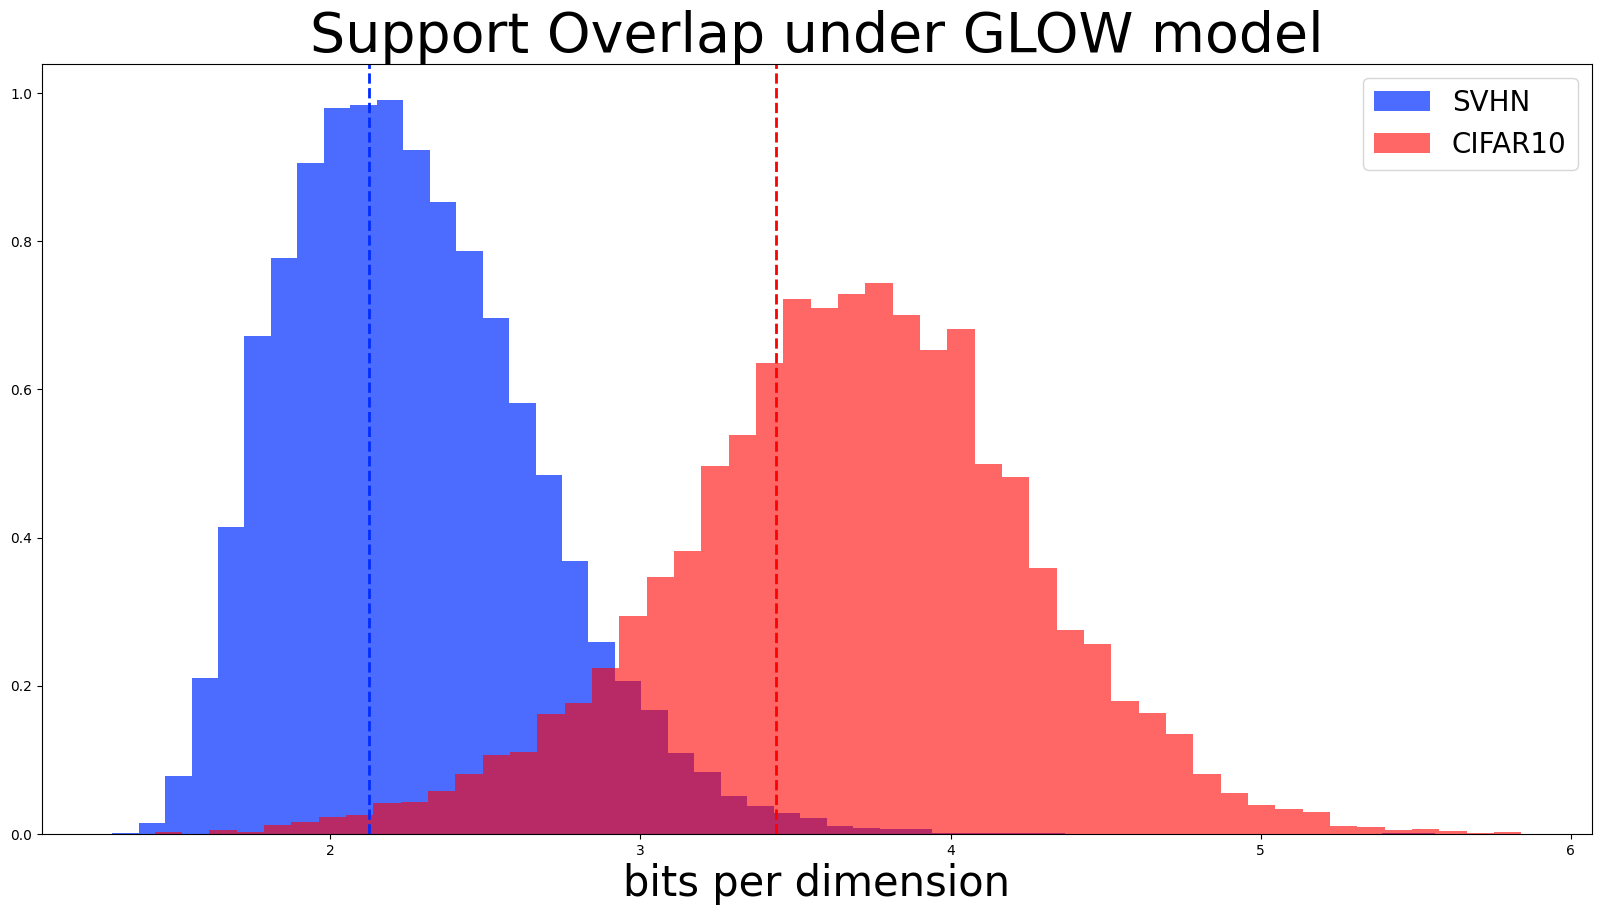

In [11]:
# 250
# CIFAR NLL 3.435947921139002
# SVHN NLL 2.1234527845771383
# Imagenet32 NLL 2.861192772409916
# Celeba NLL 3.180525192383011
# GTSRB NLL 2.747616269176948
#10
# CIFAR NLL 3.6773196013689042
# SVHN NLL 2.263177738811754
# Imagenet32 NLL 3.262624274442196
# Celeba NLL 3.3650425261800403
# GTSRB NLL 3.267467555778893
#1
# CIFAR NLL 4.264880203771591
# SVHN NLL 2.5720091812500354
# Imagenet32 NLL 3.8097166062021257
# Celeba NLL 3.824129492138592
# GTSRB NLL 3.8120213098688343

plt.figure(figsize=(20,10))
plt.title(f"Support Overlap under GLOW model",fontsize=40) #- {epo_info}")
plt.xlabel("bits per dimension", fontsize=30)

# imagenet32_nll = imagenet32_nll[~torch.isinf(imagenet32_nll)]
# imagenet32_nll = imagenet32_nll[imagenet32_nll < -6]
# plt.hist(-imagenet32_nll.numpy(), label="Imagenet32", density=True, bins=50, alpha=0.6, color='#00FF11', edgecolor='black')

plt.hist(svhn_nll, label="SVHN", density=True, bins=50, alpha=0.7,color='#002CFF')
plt.hist(cifar_nll, label="CIFAR10", density=True, bins=50, alpha=0.6, color='#FF0000')
# plt.hist(celeba_nll.numpy(), label="Celeba", density=True, bins=50, alpha=0.6,color='#F0FF00', edgecolor='black')
# plt.hist(imagenet32_nll.numpy(), label="Imagenet32", density=True, bins=50, alpha=0.6, color='#00FF11', edgecolor='black')
# plt.hist(gtsrb_nll.numpy(), label="GTSRB", density=True, bins=30, alpha=0.7,color='#00FAFF', edgecolor='black')
# plt.axvline(x=2.1234527845771383, color='#002CFF', linestyle='dashed', linewidth=2)
# plt.axvline(x=3.435947921139002, color='#FF0000', linestyle='dashed', linewidth=2)
plt.legend(fontsize=20)
output_path = path.join("images", "Support_overlap_svhn_cifar10_1.png")
plt.savefig(output_path)
plt.show()


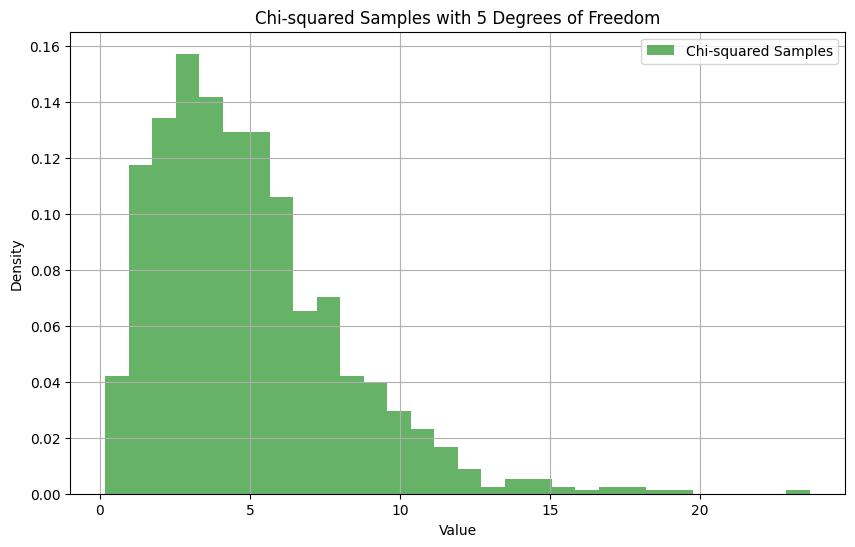

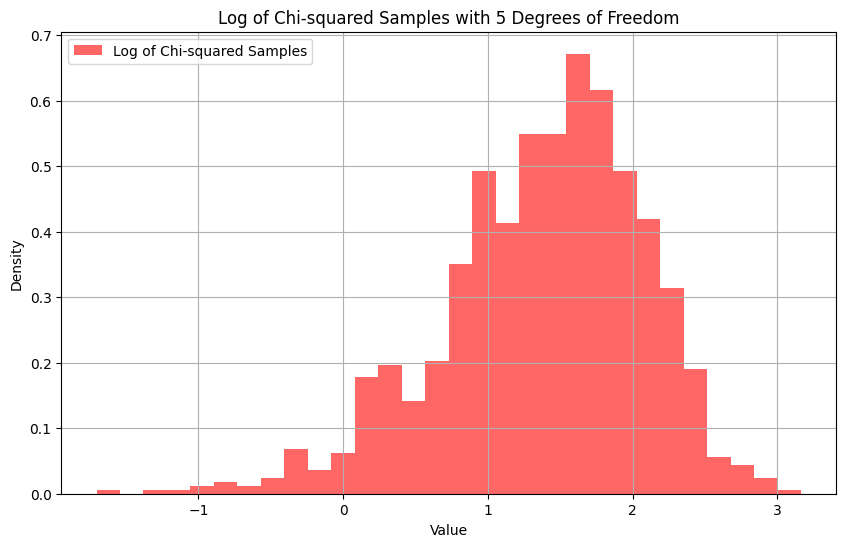

In [12]:
import numpy as np
from scipy.stats import chi2

import matplotlib.pyplot as plt
# Generate chi-squared samples
df = 5
samples = np.random.chisquare(df, 1000)

# Compute the log of the samples
log_samples = np.log(samples)

# Plot the chi-squared samples
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g', label='Chi-squared Samples')
plt.title(f'Chi-squared Samples with {df} Degrees of Freedom')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Plot the log of the chi-squared samples
plt.figure(figsize=(10, 6))
plt.hist(log_samples, bins=30, density=True, alpha=0.6, color='r', label='Log of Chi-squared Samples')
plt.title(f'Log of Chi-squared Samples with {df} Degrees of Freedom')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()